In [1]:
import os
import re
import numpy as np
import Bio.PDB as biop
import MDAnalysis as mda
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.helanal as helanal
# from MDAnalysis.tests.datafiles import PSF,DCD,CRD
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PDB_CODE = '6b73'
SEQ = '_B'
# folder_name = PDB_CODE+SEQ'

folder = '../6b73_B/1/'
# it should be the folder which contains all the initial parameters and the simultaion results
# name should be 'charmm-gui-'+folder pl: charmm-gui-6b73B
# later this folder should be copied from cluster containig the NAMD results

charmm_folder = folder+'charmm-gui-'+PDB_CODE+SEQ
print(charmm_folder)

../6b73_B/1/charmm-gui-6b73_B


In [3]:
trajectories = []
dcd_files = sorted([charmm_folder+'/namd/'+i for i in os.listdir(charmm_folder+'/namd/') if re.match(r'(step6.).*\_equilibration.dcd$', i)])
for i in range(6):
    u = mda.Universe(charmm_folder+'/step5_assembly.xplor_ext.psf', dcd_files[i])
    trajectories.append(u)

## Root mean square deviation:

Text(0.5,0,'Equilibration step')

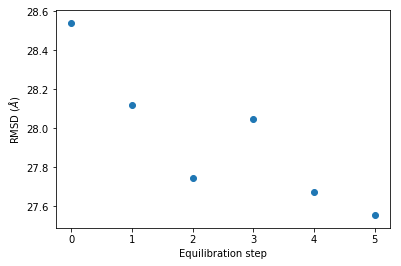

In [4]:
rmsds = []
for i in range(len(trajectories)):
    first_frame = trajectories[i].select_atoms('name CA').positions[0]
    last_frame = trajectories[i].select_atoms('name CA').positions[-1]
    rmsds.append(rms.rmsd(last_frame, first_frame))
plt.scatter(range(len(trajectories)), rmsds)
plt.ylabel('RMSD ($\AA$)')
plt.xlabel('Equilibration step')

### RMSD of backbone over time:

In [5]:
def rmsd_traj(traj, ref, plot=True):
    R = rms.RMSD(traj.select_atoms('name CA'), ref.select_atoms('name CA'), select='all').run()
    R = R.rmsd.T
    frame = R[0]
    time = R[1]
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(time, R[2])
        plt.ylabel('RMSD ($\AA$)')
        plt.xlabel('time (ps)')
        plt.title('RMSD of C-alpha atoms over equilibration steps')
    return R

array([[0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        3.82000000e+02, 3.83000000e+02, 3.84000000e+02],
       [0.00000000e+00, 1.00000000e+00, 2.00000001e+00, ...,
        6.79000002e+02, 6.81000002e+02, 6.83000002e+02],
       [1.93254259e-01, 3.47936498e-01, 4.63184291e-01, ...,
        1.25054321e+00, 1.27564075e+00, 1.26792130e+00]])

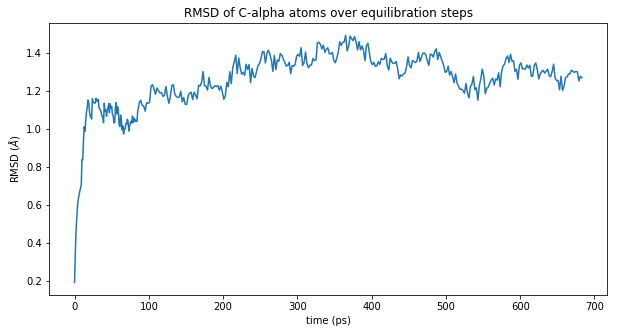

In [6]:
all_traj = mda.Universe(charmm_folder+'/step5_assembly.xplor_ext.psf', dcd_files)    
ref = mda.Universe(folder+'6b73_fin.pdb')
rmsd_traj(all_traj, ref)

## Root mean square fluctuation:

In [7]:
def secondary_structure(pdb_file):
    parser = biop.PDBParser()
    structure = parser.get_structure('6b73', pdb_file)
    model = structure[0]
    dssp = biop.DSSP(model, pdb_file)

    return {
        'helix': [np.array(np.where(np.array(dssp)[:,2] == 'H')) + 1][0][0],
        'strand': [np.array(np.where(np.array(dssp)[:,2] == 'E')) + 1][0][0],
        'pi_helix': [np.array(np.where(np.array(dssp)[:,2] == 'I')) + 1][0][0],
        'turn': [np.array(np.where(np.array(dssp)[:,2] == 'T')) + 1][0][0],
        'bend': [np.array(np.where(np.array(dssp)[:,2] == 'S')) + 1][0][0], 
    }

In [35]:
def rmsf_plot(trajectories, title, structure=False):
    fig, ax = plt.subplots(len(trajectories), sharex=True, figsize=(10, 20))
    for i in range(len(trajectories)):
        protein = trajectories[i].select_atoms("protein")
        calphas = protein.select_atoms("name CA")
        rmsfer = rms.RMSF(calphas).run()
    
        ax[i].plot(calphas.resnums, rmsfer.rmsf)

        if structure:
            for j, k, in enumerate(struct['helix']):
                ax[i].axvline(k, color='grey', alpha=0.1)

            for j, k, in enumerate(struct['pi_helix']):
                ax[i].axvline(k, color='grey', alpha=0.2)     

        ax[i].set_ylabel('RMSF ($\AA$)')
        ax[i].set_title(title.format(i+1))
    
    ax[len(trajectories)-1].set_xlabel('residue')
    plt.tight_layout()

In [16]:
pdb_file = folder+'6b73_fin.pdb'
struct = secondary_structure(pdb_file)

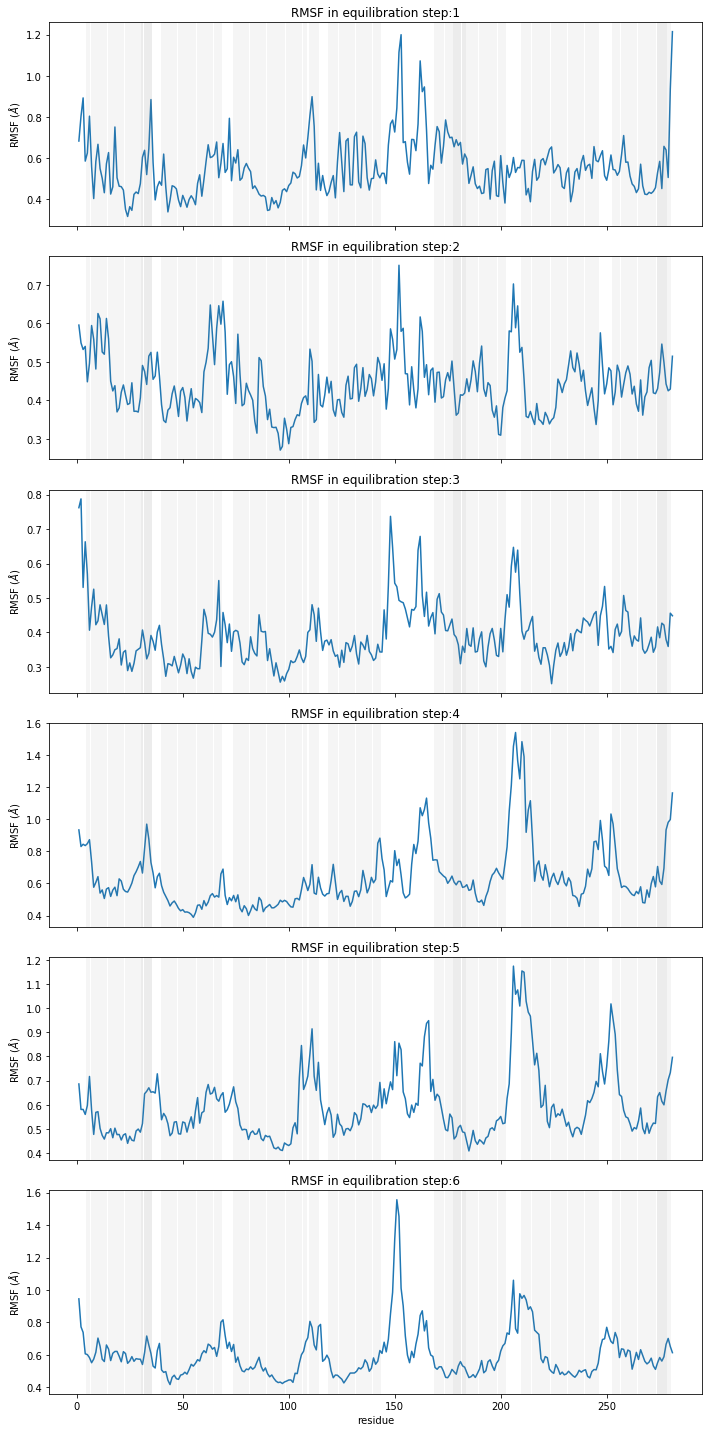

In [36]:
rmsf_plot(trajectories, title='RMSF in equilibration step:{}', structure=struct)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

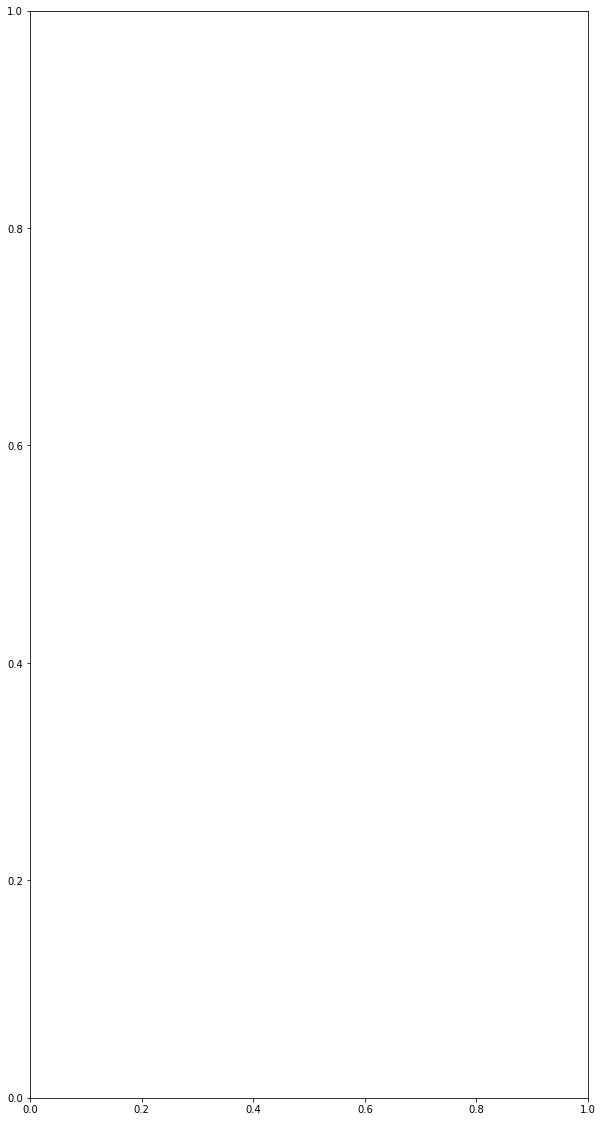

In [30]:
rmsf_plot([all_traj], title='RMSF of residues over equilibration steps', structure=struct)